In [3]:
from Utils import Utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from keras.layers import Input
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Dense, Dropout, Flatten
from keras.models import Sequential

from sklearn.model_selection import train_test_split

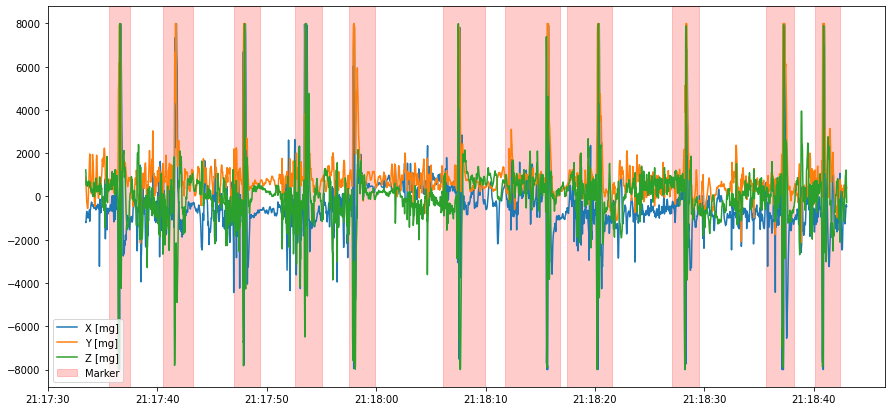

In [4]:
data_shoot_moving = Utils.read_data_csv('DATA_NEW/SHOOT_AVANT.csv')
markers_shoot_moving = Utils.read_markers('DATA_NEW/MARKER_SHOOT_AVANT.csv')
Utils.plot_with_markers(data_shoot_moving,markers_shoot_moving)

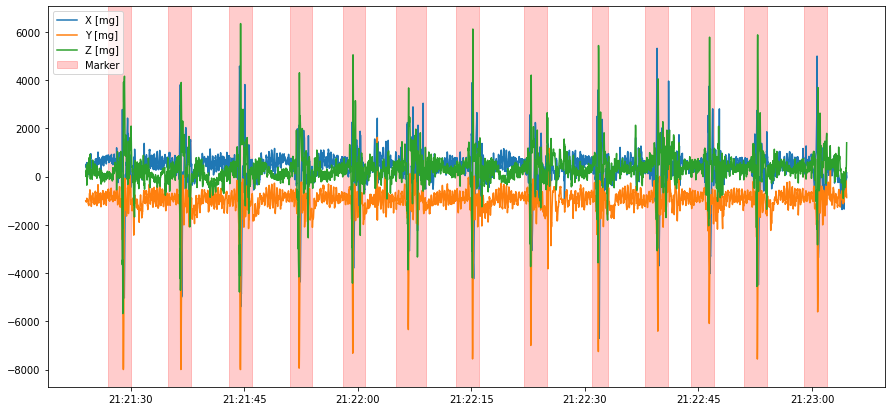

In [5]:
data_pass_moving = Utils.read_data_csv('DATA_NEW/PASSE_AVANT_THOMAS.csv')
markers_pass_moving = Utils.read_markers('DATA_NEW/MARKER_PASS_AVANT.csv')
Utils.plot_with_markers(data_pass_moving,markers_pass_moving)

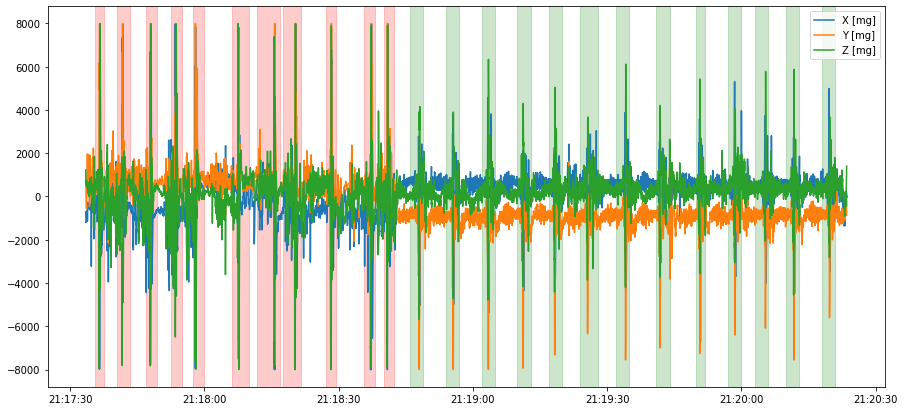

In [6]:
data_moving,markers_moving = data_backend,markers_backend = Utils.concatenate_data(data_shoot_moving.copy(),data_pass_moving.copy(),markers_shoot_moving,markers_pass_moving)
Utils.plot_with_markers_label(data_moving,markers_moving)

In [7]:
freq_sampling=50
markers_timedelta_max=np.max([end-start for (start,end,_) in markers_moving])//(2.8)
window_size=int(markers_timedelta_max.total_seconds()*freq_sampling)
window_size

89

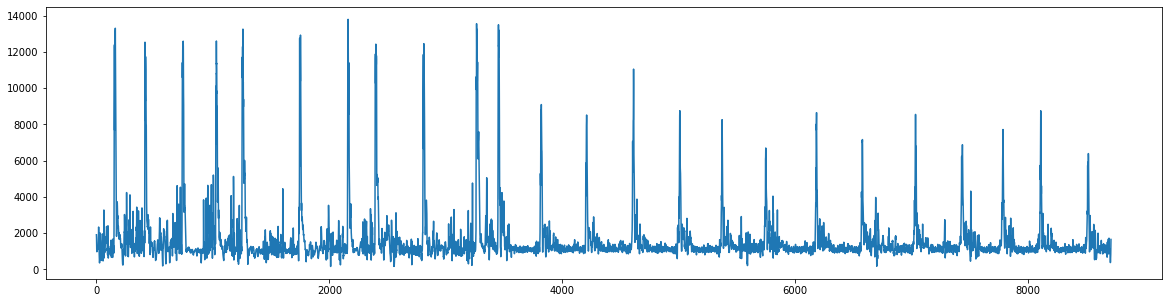

In [8]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(np.linalg.norm(data_moving,axis=1))
plt.show()

In [9]:
y_real = Utils.add_column_classification(data_moving,markers_moving)
y_real.shape

(8712,)

In [10]:
def window_slide(data, y, window_size,n_classes):
    n = len(data)//window_size
    X = np.zeros((n,window_size))
    y_block = np.zeros((n,n_classes)) 
    for i in range(n):
        X[i,:] = np.linalg.norm(data[i*window_size:(i+1)*window_size],axis=1)
        label = int(Utils.get_label(y[i*window_size:(i+1)*window_size]))
        y_block[i,label] = 1
    return X,y_block

In [11]:
n_classes = 3
X,y = window_slide(data_moving, y_real, window_size,n_classes)
print(X.shape)
print(y.shape)

(97, 89)
(97, 3)


In [31]:


model = Sequential()
model.add(Input(shape=(window_size,1),name='input'))
model.add(Conv1D(filters=32,kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(filters=16,kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(filters=8,kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(16,activation='relu'))
model.add(Dense(n_classes,activation='softmax'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 89, 32)            192       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 22, 32)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 22, 16)            2576      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 5, 16)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 5, 8)              392       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 2, 8)            

In [13]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.33)

X_train = X_train.reshape(len(X_train),window_size,1)
X_test = X_test.reshape(len(X_test),window_size,1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(64, 89, 1)
(33, 89, 1)
(64, 3)
(33, 3)


In [49]:
batch_size = 8
n_epoch = 50

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(X_train, y_train,class_weight={0:1.,1:1.5,2:1.5}, batch_size=batch_size, epochs=n_epoch, verbose=1, validation_split=0.2)

Epoch 1/50
7/7 [==============================] - 2s 63ms/step - loss: 1.3620 - accuracy: 0.1765 - val_loss: 1.1298 - val_accuracy: 0.2308
Epoch 2/50
7/7 [==============================] - 0s 13ms/step - loss: 1.3603 - accuracy: 0.2353 - val_loss: 1.1252 - val_accuracy: 0.2308
Epoch 3/50
7/7 [==============================] - 0s 13ms/step - loss: 1.3563 - accuracy: 0.2157 - val_loss: 1.1223 - val_accuracy: 0.2308
Epoch 4/50
7/7 [==============================] - 0s 13ms/step - loss: 1.3549 - accuracy: 0.2157 - val_loss: 1.1191 - val_accuracy: 0.2308
Epoch 5/50
7/7 [==============================] - 0s 15ms/step - loss: 1.3571 - accuracy: 0.1176 - val_loss: 1.1153 - val_accuracy: 0.2308
Epoch 6/50
7/7 [==============================] - 0s 15ms/step - loss: 1.3531 - accuracy: 0.2157 - val_loss: 1.1128 - val_accuracy: 0.2308
Epoch 7/50
7/7 [==============================] - 0s 15ms/step - loss: 1.3522 - accuracy: 0.2353 - val_loss: 1.1100 - val_accuracy: 0.2308
Epoch 8/50
7/7 [===========

Test score: 1.0533119440078735
Test accuracy: 0.6666666865348816


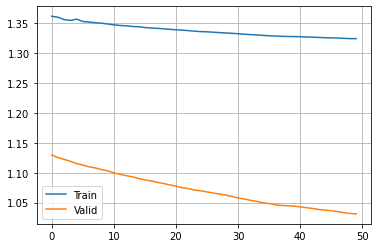

In [50]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Valid')
plt.legend()
plt.grid()

score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [51]:
y_pred = model.predict(X_test)

In [52]:
y_pred_label = np.argmax(y_pred,axis=1).astype('int32')
y_pred_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [43]:
y_test_label = np.argmax(y_test,axis=1).astype('int32')
y_test_label

array([0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 1, 2, 2, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 2, 0, 1, 0, 2, 0, 0])

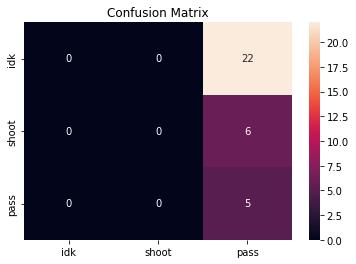

In [44]:
Utils.plot_confusion_matrix(y_test_label,y_pred_label)

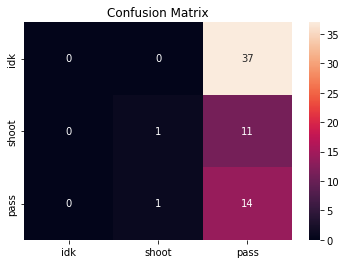

In [28]:
y_pred = model.predict(X_train)

y_pred_label = np.argmax(y_pred,axis=1).astype('int32')

y_train_label = np.argmax(y_train,axis=1).astype('int32')

Utils.plot_confusion_matrix(y_train_label,y_pred_label)

In [54]:
# LSTM -> stateless
# class_weight
# https://keras.io/keras_tuner/

In [55]:
import keras_tuner as kt
import keras

In [57]:
def build_model(hp):
    model = keras.Sequential()
    model.add(
        Conv1D(
            hp.Choice('filters',[8,16,32]),
            hp.Choice('kernel_size',[3,5,7]),
            padding='same', activation='relu'
            )
        )
    model.add(MaxPooling1D(pool_size=4))
    model.add(
        Conv1D(
            hp.Choice('filters',[8,16,32]),
            hp.Choice('kernel_size',[3,5,7]),
            padding='same', activation='relu'
            )
        )
    model.add(MaxPooling1D(pool_size=4))
    model.add(Flatten())
    
    model.add(Dense(hp.Choice('units', [8, 16, 32]),activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(n_classes,activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

In [58]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

In [59]:
tuner.search(X_train, y_train, epochs=35,batch_size=8, validation_split=0.2)

Trial 5 Complete [00h 00m 09s]
val_loss: 0.7515544891357422

Best val_loss So Far: 0.7515544891357422
Total elapsed time: 00h 00m 48s
INFO:tensorflow:Oracle triggered exit


In [67]:
best_model = tuner.get_best_models()[0]

In [71]:
best_model.build(input_shape=(None,window_size,1))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             multiple                  192       
                                                                 
 max_pooling1d (MaxPooling1D  multiple                 0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           multiple                  5152      
                                                                 
 max_pooling1d_1 (MaxPooling  multiple                 0         
 1D)                                                             
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  5

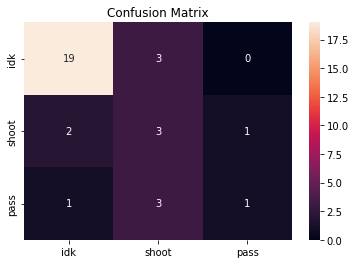

In [73]:
y_pred = best_model.predict(X_test)

y_pred_label = np.argmax(y_pred,axis=1).astype('int32')

y_train_label = np.argmax(y_test,axis=1).astype('int32')

Utils.plot_confusion_matrix(y_train_label,y_pred_label)